# Importing Packages and Config

In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from ipywidgets import  fixed
import ipywidgets as widgets
import ipywidgets as interactive
plt.rcParams['figure.figsize'] = [16,8]
from IPython.display import clear_output


#### Some Misc Functions

In [2]:
def fmt(x):
    if x >= 10**6:
        return f'{x/10**6:.1f}M'
    elif x >= 10**3:
        return f'{x/10**3:.1f}K'
    else:
        return f'{x:.0f}'

def convert_from_seconds(sec, to = 'days'):
    sec = sec.total_seconds()
    match to:
        case 'months':
            return sec / 60 / 60 / 24 / 30
        case 'days':
            return sec / 60 / 60 / 24
        case 'hours':
            return sec / 60 / 60
        case 'minutes':
            return sec / 60
        case 'seconds':
            return sec
        case _:
            raise ValueError(f'Unknown unit {to}')

def assign_grouping(value,values):
  for group in values:
    if group in value:
      return group
  return 'Other'

# Importing the dataset

In [3]:
df_orig = pd.read_csv('../data/311.csv', low_memory=False)

In [4]:
df = df_orig.copy(deep=True)

# Convert dates

In [6]:
df['open_dt'] = pd.to_datetime(df['open_dt'],format='%Y-%m-%d %H:%M:%S')
df['sla_target_dt'] = pd.to_datetime(df['sla_target_dt'],format='%Y-%m-%d %H:%M:%S')
df['closed_dt'] = pd.to_datetime(df['closed_dt'],format='%Y-%m-%d %H:%M:%S')

#### Some misc variables

In [7]:
year_range = df.open_dt.dt.year.agg(['min','max'])
year_min = year_range['min']
year_max = year_range['max']

# Base Questions

## What is the total volume of requests per year or how many 311 requests is the city receiving per year?

In [9]:
%%html
<style>
/*overwrite hard coded write background by vscode for ipywidges */
.cell-output-ipywidget-background {
   background-color: transparent !important;
}

/*set widget foreground text and color of interactive widget to vs dark theme color */
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

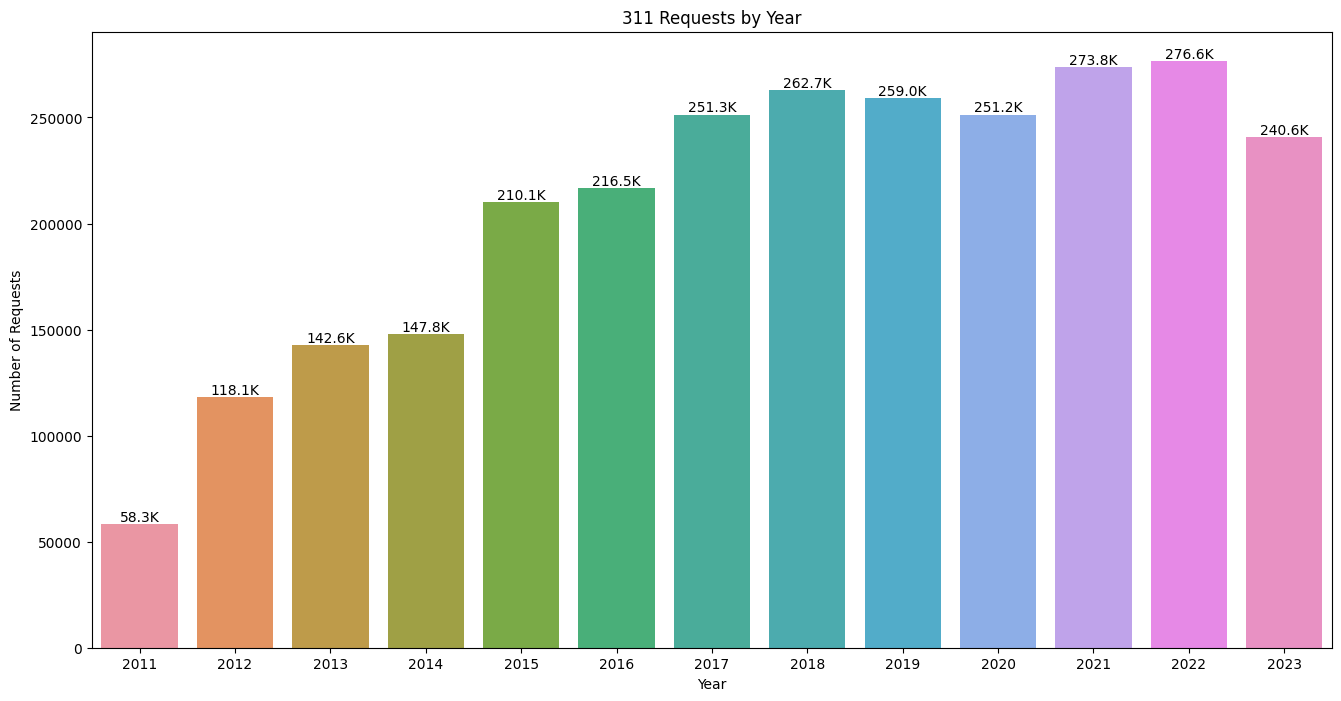

In [27]:
def plot_year_volume():
    fig = sns.countplot(df,x=df['open_dt'].dt.year)
    fig.bar_label(fig.containers[0], fmt=fmt, label_type='edge')
    fig.set(xlabel='Year', ylabel='Number of Requests')
    plt.title('311 Requests by Year')
    plt.show()

plot_year_volume()

## Which service requests are most common for the city overall AND by NEIGHBORHOOD and how is this changing year over year by SUBJECT (department), REASON,QUEUE?

In the neighborhood column there are a lot of null values and also values that are ' ', i.e. string with one space character. 

We decided to change these values to one common name, 'No Neighborhood', so no piece of data will be lost.

In [20]:
df['neighborhood'] = df['neighborhood'].fillna(' ')
# now replace all ' ' values with 'No Neighborhood'
df.loc[df.neighborhood == ' ','neighborhood'] = 'No Neighborhood'

## How is the case volume changing by submission channel SOURCE?

IntRangeSlider(value=(2011, 2023), description='Years:', layout=Layout(width='40%'), max=2023, min=2011)

Button(description='Plot', style=ButtonStyle())

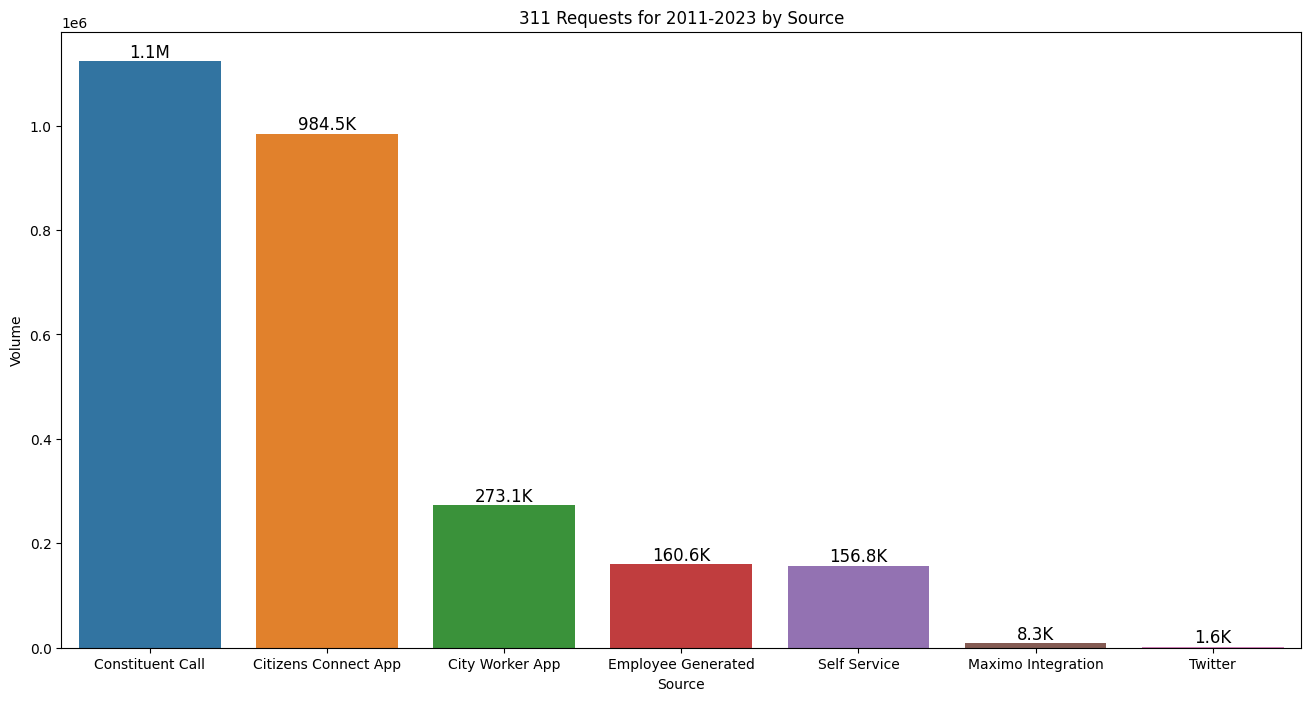

In [28]:
year_slider_source = widgets.IntRangeSlider(
    value=[year_min,year_max],
    min=year_min,
    max=year_max,
    step=1,
    description='Years:',
    layout=widgets.Layout(width='40%')
)

plot_button_source = widgets.Button(description='Plot')


def plot_by_source():
    years = year_slider_source.value
    filtered = df[df.open_dt.dt.year.between(years[0],years[1])]

    fig = sns.countplot(data=filtered, x='source',order=filtered['source'].value_counts().index)
    
    fig.bar_label(fig.containers[0],fmt = fmt, fontsize=12)
    fig.set(xlabel='Source',ylabel='Volume')

    if years[0] == years[1]:
        plt.title(f'311 Requests for {years[0]} by Source')
    else:
        plt.title(f'311 Requests for {years[0]}-{years[1]} by Source')

    plt.show()





def button_click_source(b):
    clear_output(wait=True)
    display(year_slider_source)
    display(plot_button_source)
    plot_by_source()
    
plot_button_source.on_click(button_click_source)
plot_button_source.click()

## What is the average # of daily contacts by year?

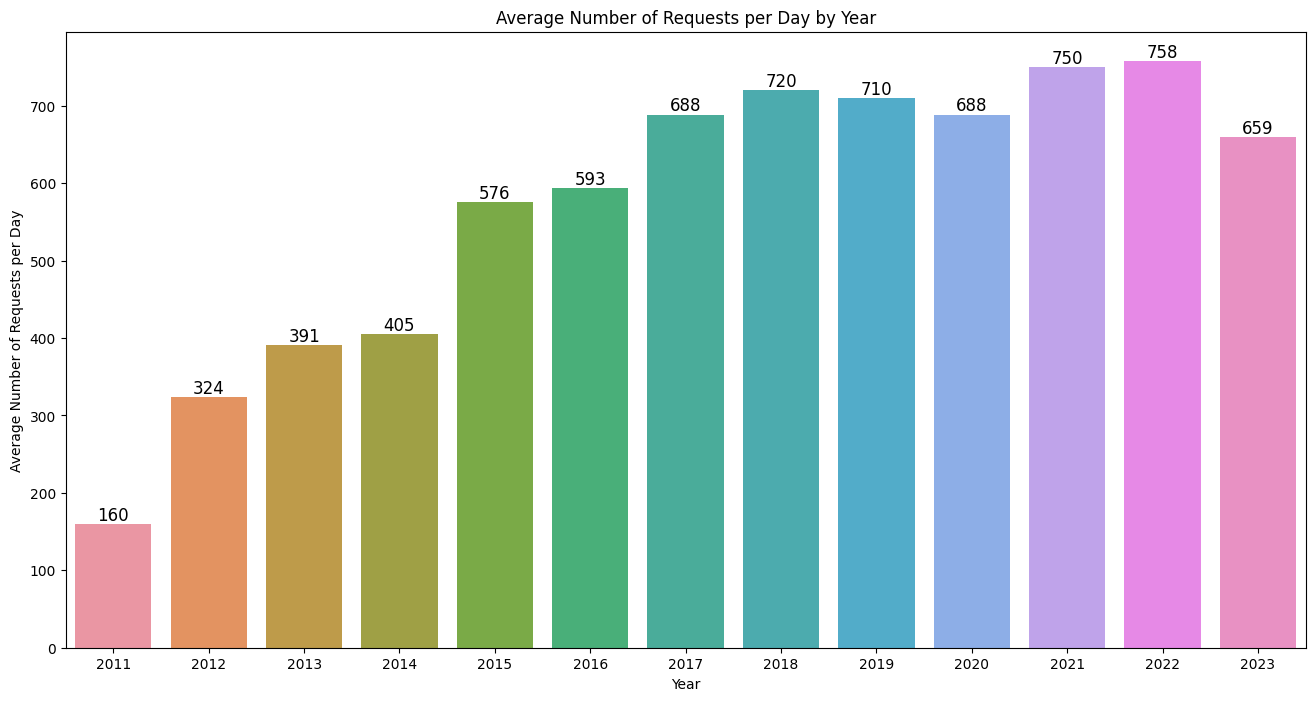

In [29]:
def plot_day_average():
    averages = df.groupby(df['open_dt'].dt.year)['case_enquiry_id'].count() / 365
    plt.title('Average Number of Requests per Day by Year')
    fig = sns.barplot(x=averages.index,y=averages)
    fig.bar_label(fig.containers[0], fmt=fmt, fontsize=12)
    fig.set(xlabel='Year',ylabel='Average Number of Requests per Day')
    plt.show()

plot_day_average()

## Volume of top 5 request types (TYPE)

IntRangeSlider(value=(2011, 2023), description='Years:', layout=Layout(width='40%'), max=2023, min=2011)

Button(description='Plot', style=ButtonStyle())

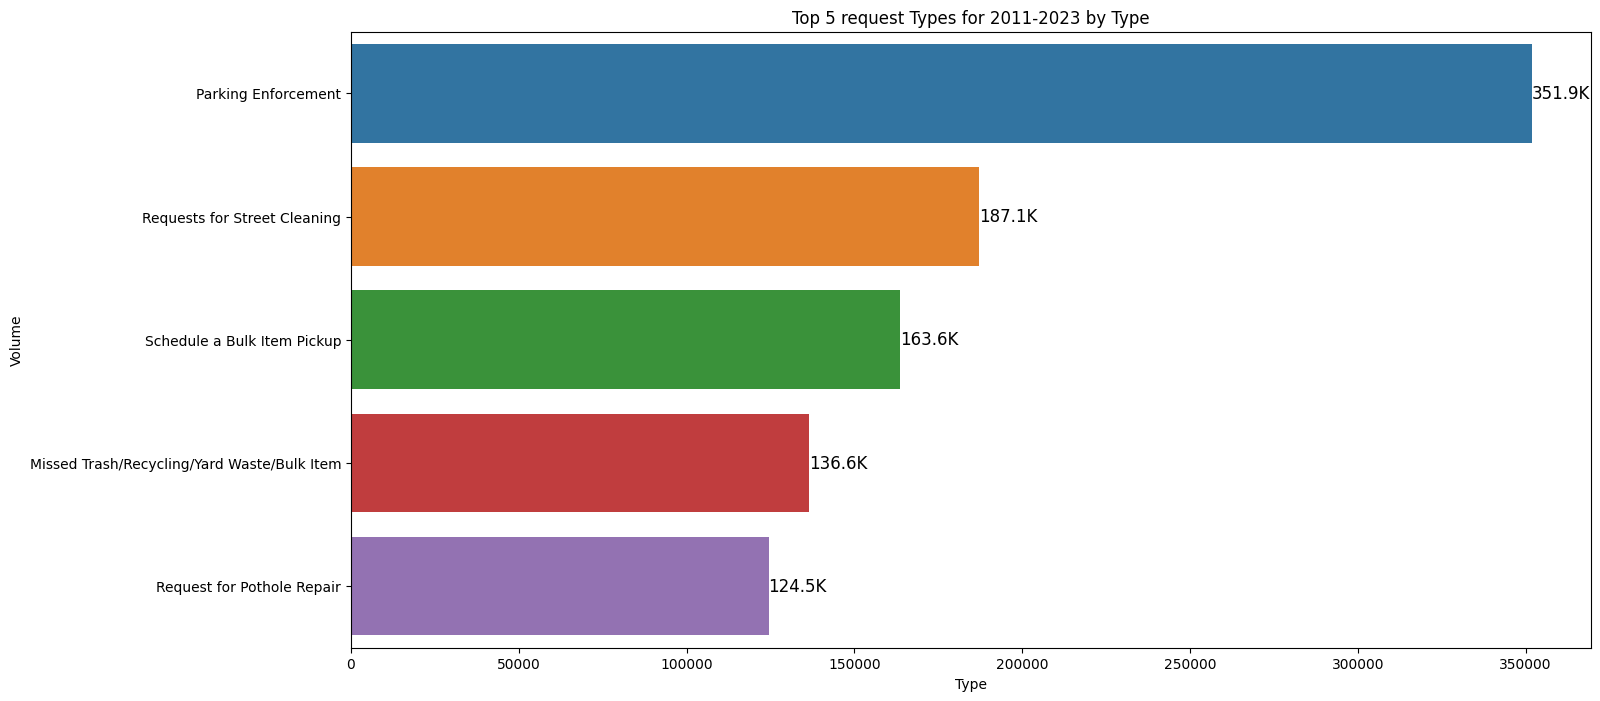

In [32]:
year_slider_type = widgets.IntRangeSlider(
    value=[year_min,year_max],
    min=year_min,
    max=year_max,
    step=1,
    description='Years:',
    layout=widgets.Layout(width='40%')
)

plot_button_type = widgets.Button(description='Plot')

def plot_type():
    years = year_slider_type.value
    filtered = df[df.open_dt.dt.year.between(years[0],years[1])]

    if years[0]==years[1]:
        plt.title(f'Top 5 request Types for {years[0]} by Type')
    else:
        plt.title(f'Top 5 request Types for {years[0]}-{years[1]} by Type')

    fig = sns.countplot(data=filtered,y='type',order=filtered['type'].value_counts().iloc[:5].index)

    fig.bar_label(fig.containers[0],fmt=fmt,fontsize=12)
    fig.set(xlabel='Type',ylabel='Volume')

    plt.show()


def button_click_type(b):
    clear_output(wait=True)
    display(year_slider_type)
    display(plot_button_type)
    plot_type()

plot_button_type.on_click(button_click_type)
plot_button_type.click()

## Average goal resolution time by QUEUE



Let's add a new column, called resolution_time, which shows how much time was spent on a request

In [33]:
df['resolution_time'] = df['closed_dt'] - df['open_dt'] # add new column for resolution time
df['resolution_time'].describe()

count                        2513216
mean      31 days 07:22:48.904903912
std      159 days 01:27:55.353008794
min                -1 days +23:59:02
25%                  0 days 01:31:12
50%                  0 days 18:02:33
75%           5 days 17:05:57.250000
max               4417 days 23:00:22
Name: resolution_time, dtype: object

Since there are values with negative dates, let's set them equal to 0

In [34]:
from datetime import timedelta
df.loc[df['resolution_time'] < timedelta(0),'resolution_time'] = timedelta(seconds=0)
df['resolution_time'].describe()

count                        2513216
mean      31 days 07:22:48.907035046
std      159 days 01:27:55.352589326
min                  0 days 00:00:00
25%                  0 days 01:31:12
50%                  0 days 18:02:33
75%           5 days 17:05:57.250000
max               4417 days 23:00:22
Name: resolution_time, dtype: object

There are 181 different queues, so we have to split them into groups.


First, we will split groups by department, then group inside if needed.

These are the groups we end up with:

1. PWD Group
2.  BTDT Group
3.  ISD Group
4.  INFO Group
5.  PARK Group
6.  Other Group


Since PWD Group has 70 unique queues, we applied custom grouping

1. Engineering : 
2. Repair
3. Highway
4. Snow
5. Street Light
6. Complaint
7. Recycling
8. Other
9. Litter Basket
10. District


RadioButtons(index=5, layout=Layout(display='flex', flex_flow='row'), options=('PWDx', 'BTDT', 'PARK', 'INFO',…

Button(description='Plot', style=ButtonStyle())

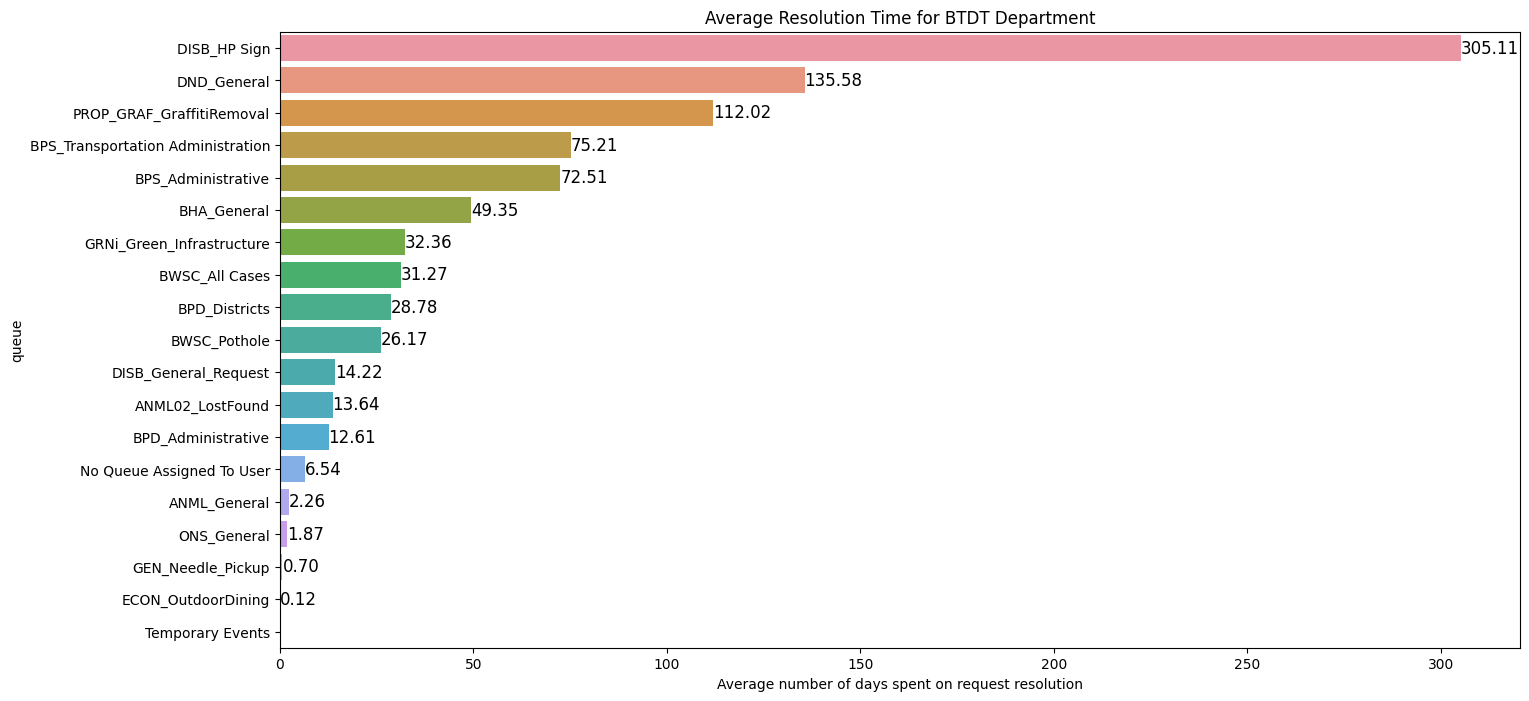

In [ ]:
department_radio_buttons = widgets.RadioButtons(
    options = ['PWDx','BTDT','PARK','INFO','ISD','Other'],
    layout=widgets.Layout(display='flex',flex_flow='row')
)

plot_button_art = widgets.Button(description='Plot')

def plot_art():
    def plot_pwd():
        plt.title(f'311 Requests by Queue for PWDx Department')
        group = ['Recycling','District','Street Light','Highway','Snow','Repair','Complaint','Litter Basket','Engineering']
        only_department_group = df.loc[df['department'] == department].copy(deep=True)
        only_department_group['queue_group'] = only_department_group['queue'].apply(lambda entry: assign_grouping(entry,group))
        average_resolution_times = only_department_group.groupby('queue_group')['resolution_time'].mean().reset_index()

        fig = sns.barplot(average_resolution_times,y='queue_group',x=average_resolution_times['resolution_time'].apply(convert_from_seconds),order=average_resolution_times.sort_values(by='resolution_time',ascending=False)['queue_group'])
        plt.title(f'Average Resolution Time for {department} Department')
        fig.bar_label(fig.containers[0],fmt='%.2f',fontsize=12)
        fig.set(xlabel='Average number of days spent on request resolution')
        plt.show()
    
    def plot_department(departments):
        average_resolution_times = df.loc[df['department'].isin(departments)].groupby('queue')['resolution_time'].mean().reset_index()
        fig = sns.barplot(average_resolution_times, y='queue',x=average_resolution_times['resolution_time'].apply(convert_from_seconds),order=average_resolution_times.sort_values(by='resolution_time',ascending=False)['queue'])
        plt.title('Average Resolution Time for BTDT Department')
        fig.bar_label(fig.containers[0],fmt='%.2f',fontsize=12)
        fig.set(xlabel='Average number of days spent on request resolution')
        plt.show()
    
    department = department_radio_buttons.value
    
    match department:
        case 'PWDx':
            plot_pwd()
        case 'Other':
            plot_department(df[~df['department'].isin(['PWDx','BTDT','PARK','INFO','ISD'])]['department'].unique())
        case _:
            plot_department([department])

def on_button_clicked(b = None):
    clear_output(wait=True)
    display(department_radio_buttons)
    display(plot_button_art)
    plot_art()

plot_button_art.on_click(on_button_clicked)
plot_button_art.click()

## Average goal resolution time by QUEUE and neighborhood}

'0.000001'

## What % of service requests are closed (CLOSED_DT or CASE_STATUS) vs. no data (CASE_STATUS = null) vs. unresolved (CASE_STATUS = open)?

IntRangeSlider(value=(2011, 2023), description='Years:', layout=Layout(width='40%'), max=2023, min=2011)

Button(description='Plot', style=ButtonStyle())

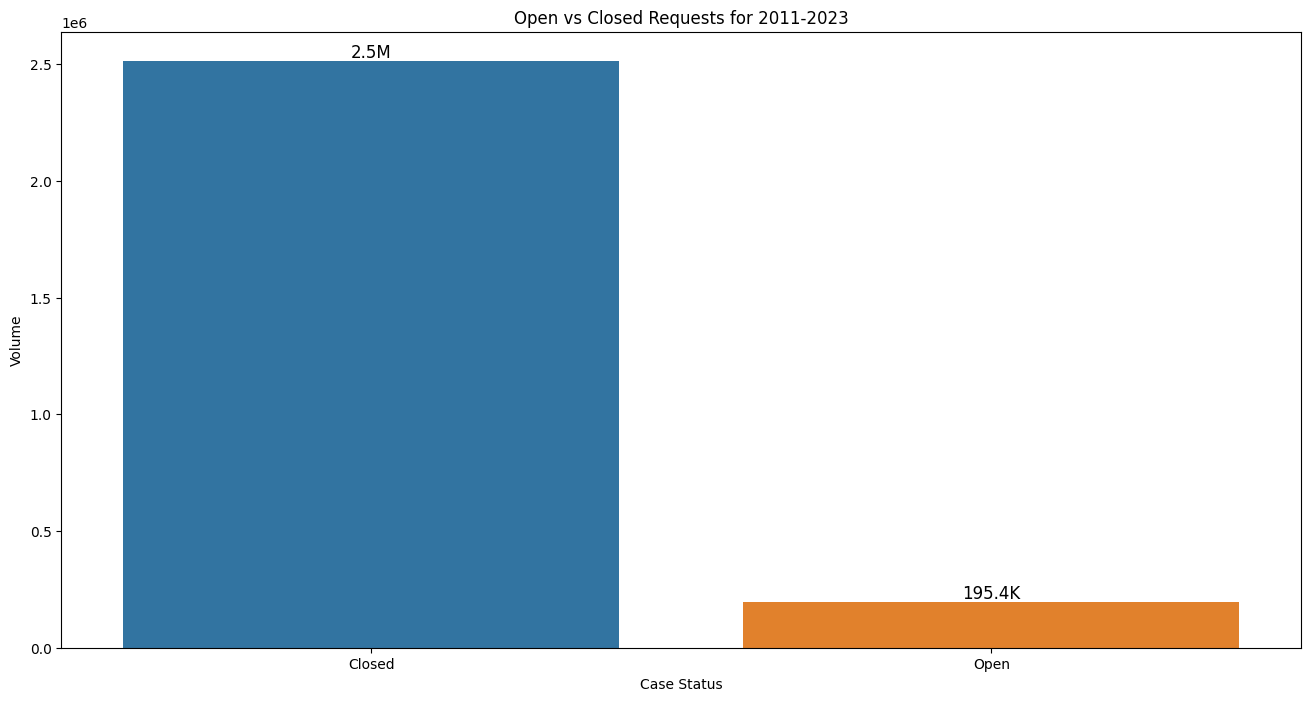

In [47]:
year_slider_case_status = widgets.IntRangeSlider(
    value=[year_min,year_max],
    min=year_min,
    max=year_max,
    step=1,
    description='Years:',
    layout=widgets.Layout(width='40%')
)

plot_button_case_status = widgets.Button(description='Plot')


def plot_case_status():
    years = year_slider_case_status.value
    filtered = df[df.open_dt.dt.year.between(years[0],years[1])]

    if years[0]==years[1]:
        plt.title(f'Open vs Closed Requests for {years[0]}')
    else:
        plt.title(f'Open vs Closed Requests for {years[0]}-{years[1]}')

    fig = sns.countplot(data=filtered,x='case_status',order=filtered['case_status'].value_counts().index)

    fig.bar_label(fig.containers[0],fmt=fmt,fontsize=12)
    fig.set(xlabel='Case Status',ylabel='Volume')

    plt.show()


def button_click_case_status(b):
    clear_output(wait=True)
    display(year_slider_case_status)
    display(plot_button_case_status)
    plot_case_status()

plot_button_case_status.on_click(button_click_case_status)
plot_button_case_status.click()